# import Data
## import and install important libraries

In [ ]:
from sklearn import preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import json
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [ ]:
'''!pip uninstall nltk
!pip install nltk==3.2.5
import nltk'''

In [ ]:
import emoji#checking if a character is an emoji
import re
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize 
from nltk.corpus import stopwords 
from nltk import sent_tokenize, word_tokenize
import time

In [ ]:
'''folder=f'/Users/livi/Documents/2020 Fall/data mining/Proposal/Final Paper/Tweets_Half_Cleaned/'
FinFolder=os.listdir(folder)
Frame=[]
for file in FinFolder[:]:
    if (file.endswith('.csv')) & (file!='.DS_Store'):
        One_Frame=pd.read_csv(join(folder,file),lineterminator='\n',index_col=0)
        Frame.append(One_Frame)
T=pd.concat(Frame)
T.reset_index(inplace=True,drop=True)'''

In [ ]:
#T=pd.read_csv('/Users/livi/Git/Tweepy-data-mining/T12292020.csv', index_col=0,lineterminator='\n')

In [ ]:
T=pd.read_csv('/Users/livi/Git/Tweepy-data-mining/LIWC2015 Results (T12292020).csv', index_col=0,lineterminator='\n')

In [ ]:
#rename columnsT
T_cols=list(T.columns)
T_cols[:18]=['created_at', 'source', 'extended_tweet', 'location', 'CountryCode','SDG', 'id', 'name', 'screen_name', 'url', 'friends_count','followers_count', 'hashtags', 'extended_tweet_lemmatized', 'neg','neu', 'pos', 'compound']
T.columns=T_cols

# LIWC columns
AffectWords=['posemo', 'negemo', 'anx', 'anger', 'sad']
CognetiveProcess=['insight', 'cause', 'discrep', 'tentat', 'certain', 'differ']
PerpetualProcesses=['see', 'hear', 'feel']
BiologicalProcesses=['bio', 'body', 'health', 'sexual', 'ingest']
CoreDrivesandNeeds=['affiliation', 'achieve', 'power', 'reward', 'risk']
TimeOrientation=['focuspast', 'focuspresent', 'focusfuture']
Relativity=['motion', 'space', 'time']
PersonalConcerns=['work', 'leisure', 'home', 'money', 'relig', 'death']
InformalSpeech=['informal','swear','netspeak','assent','nonflu','filler']

In [ ]:
#drop ['location','name','url']
desired_col=['created_at', 'source', 'extended_tweet', 'CountryCode','SDG', 'id', 'screen_name','followers_count', 'hashtags', 'extended_tweet_lemmatized', 'neg','neu', 'pos', 'compound']
for i in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech']:
  desired_col.extend(eval(i))
T=T[desired_col]
T.drop(index=T[pd.isnull(T['extended_tweet'])].index,inplace=True)
T.drop(index=T[pd.isnull(T['id'])].index,inplace=True)
T.reset_index(drop=True,inplace=True)

In [ ]:
#Country code clean
for i,k in enumerate(T['CountryCode']):
    if ']' in str(k):
        T.loc[i,'CountryCode']='nan'

In [ ]:
#str
for col in ['source','extended_tweet','CountryCode','id','extended_tweet_lemmatized']:
    T[col]=T[col].astype(str)
'''#num
for col in ['friends_count','followers_count','neg','neu','pos','compound']:
    T[col]=T[col].astype(float)'''
#apply
for col in ['SDG','hashtags']:
    T[col]=T[col].apply(eval)

In [ ]:
for i in T.columns:
    if T[i].dtypes=='float64':
        T[i].replace(0,np.nan,inplace=True)

In [ ]:
T.info()

# Data Cleaning

## Generate user information

### Detect Bot and Consider label Bot
1. interarrival time is smaller than 5 seconds(Tested, mainly small intervals are caused by long tweets)
2. other weird resource (source from bot may have interarrival time much longer 5 sec) Most effective method
3. number of tweets per day (statuses_count, not used here, because there are accounts which frequently tweets)

number of Influencer:A micro-influencer is someone who has between 1,000 to 100,000 followers

In [ ]:
#Assign user type
T['UserType']=''
screen_name_of_bots=list(T[T['source'].str.contains('bot')]['screen_name'].unique())
screen_name_of_bots.extend(['trendsinAI','form_bot','UDHROne257_247','globalhealthbot'])
screen_name_of_bots.extend(list(T[T['screen_name'].str.contains('retweet',case=False)]['screen_name'].unique()))
BFF=T[['screen_name','followers_count']].groupby(['screen_name']).agg({'followers_count':'max'}).reset_index()
#assign user
screen_name_of_user=list(BFF[(BFF['followers_count']<=800)]['screen_name'].unique())
T.loc[(T['screen_name'].isin(screen_name_of_user))& (~ T['screen_name'].isin(screen_name_of_bots)),'UserType']='user'
#assign influencer
screen_name_of_influencer=list(BFF[(BFF['followers_count']>800)]['screen_name'].unique())
screen_name_of_influencer.extend(list(T[T['screen_name'].str.contains('news',case=False)]['screen_name'].unique()))
T.loc[(T['screen_name'].isin(screen_name_of_influencer)) & (~ T['screen_name'].isin(screen_name_of_bots)),'UserType']='influencer'
#assign bots
T.loc[T['screen_name'].isin(screen_name_of_bots),'UserType']='bot'

In [ ]:
T=T[T['UserType']=='user'].reset_index(drop=True)

In [ ]:
T.shape

### include other SDG according to the keywords

In [ ]:
#choose to include keywords for sdgs or not
'''keyword_list=[['#poverty'],['#zerohunger'],['#globalhealth'],['#education'],['#genderequality'],['#water'],['#energy'],['#decentwork'],['#economicgrowth','#ideas'],['#socialjustice'],['#sustainablecities'],['#sparetosave'],['#climateaction'],['#ocean'],['#lifeonland'],['#justice','#peace']]
for i in range(16):
    for ii in keyword_list[i]:
        for iii in T[T['extended_tweet'].str.contains(ii,case=False)].index:
            T.loc[iii,'SDG'].append('SDG'+str(i+1))
        #print(i+1,keyword_list[i],ii)'''

###  Generate labels topic

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
'''PopSDGs=['SDG'+str(i) for i in [4,5,7,2,16]]
for PopSDG in PopSDGs:
  searchTerm = PopSDG
  TextExt=T[[searchTerm in x for x in T['SDG']]]
  #parameter set-up
  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')
  LDA = LatentDirichletAllocation(n_components=5, random_state=42)
  #topic modeling
  tweet_matrix=count_vect.fit_transform(TextExt['extended_tweet_lemmatized'].values.astype('U'))
  LDA.fit(tweet_matrix)
  #print results
   for i in top_topic_words:
      print(count_vect.get_feature_names()[i])
  for i,topic in enumerate(LDA.components_):
      print(f'Top 20 words for {PopSDG} topic #{i}:')
      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-20:]])
      print('\n')
  print('*'*50)
  #put topic back to tweets
  topic_values = LDA.transform(tweet_matrix)
  T[PopSDG+'Topic']=None
  #putinto the main matrix
  T.loc[TextExt.index,PopSDG+'Topic']=topic_values.argmax(axis=1)'''

# Analysis

In [ ]:
Users=T[['screen_name','id','UserType','source']].groupby('screen_name').agg({'id':'count','UserType':'last','source':'last'})

In [ ]:
Users.sort_values('id',ascending=False,inplace=True)
Users.reset_index(inplace=True)

In [ ]:
cri_bot=Users['UserType']=='bot'
cri_user=Users['UserType']=='user'
cri_influencer=Users['UserType']=='influencer'

In [ ]:
set(Users['screen_name'].to_list()[:30]).intersection(set(Users[cri_user]['screen_name'].to_list()[:15]))

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(Users['screen_name'].to_list()[:40],Users['id'].to_list()[:40])
plt.title('All', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_bot]['screen_name'].to_list()[:15],Users[cri_bot]['id'].to_list()[:15])
plt.title('Bot', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_user]['screen_name'].to_list()[:30],Users[cri_user]['id'].to_list()[:30])
plt.title('User', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_influencer]['screen_name'].to_list()[:15],Users[cri_influencer]['id'].to_list()[:15])
plt.title('Influencer', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
T[['screen_name','id','UserType','source']].groupby('UserType').agg({'id':'count','source':'last','screen_name':'last'})

# Analysis

## Frequency of SDG

In [ ]:
TT=T[['extended_tweet', 'SDG','CountryCode']]

In [ ]:
TT['length']=TT['SDG'].apply(lambda x: type(x))

In [ ]:
for n,i in enumerate(TT['SDG']):
    if isinstance(i,float):
        TT.drop(index=n,inplace=True)
        T.drop(index=n,inplace=True)
TT.reset_index(drop=True, inplace=True)
T.reset_index(drop=True, inplace=True)

In [ ]:
TT['length']=TT['SDG'].apply(lambda x: len(x))

In [ ]:
TT=TT[[len(i)>0 for i in TT['SDG']]]
TT.reset_index(drop=True,inplace=True)
print(TT.shape)
TT.head()

In [ ]:
#Clean up the string
Tdict={}
for i in TT['SDG'].to_list():
    for ii in i:
        if ii in Tdict:
            Tdict[ii]+=1
        else:
            Tdict[ii]=1
#Tdict['']+=Tdict['']
try:
  Tdict['SDG1']+=Tdict['SDG01']
  Tdict['SDG8']+=Tdict['SDG08']
  Tdict['SDG6']+=Tdict['SDG64']
  Tdict['SDG4']+=Tdict['SDG04']
  del Tdict['SDG01']
  del Tdict['SDG04']
  #del Tdict['SDG4ALL']
  #del Tdict['SDG4B']
  #del Tdict['SDG4IT']
  #del Tdict['SDG4SURVEY']
  #del Tdict['SDG4PT7']
  del Tdict['SDG64']
  del Tdict['SDG08']
  del Tdict['SDG18']
  del Tdict['SDG200']
  del Tdict['SDG2030']
  del Tdict['SDG2020']
  del Tdict['SDG19']

except:
  #raise
  pass
Tdict={k:v for k,v in sorted(Tdict.items(), key=lambda x: x[1],reverse=True)}
sorted(Tdict)

In [ ]:
print(Tdict.keys())
plt.figure(figsize=(20,10))
plt.bar(Tdict.keys(),Tdict.values())
plt.xlabel('SDG',fontsize=25,weight='bold')
plt.xticks(fontsize=20,weight='bold',rotation=90)
plt.yticks(fontsize=20,weight='bold',rotation=90)
plt.ylabel('Frequency',fontsize=25,weight='bold')
plt.tight_layout()
#plt.savefig('SDG popularity.jpg',dpi=300)
plt.show()

## Generate National Graph
### import libraty and geojson

In [ ]:
import folium

In [ ]:
with open('/Users/livi/Git/Tweepy-data-mining/countries.geojson') as f:
  geodata = json.load(f)

In [ ]:
holdlist=[]
allcountries=[]
for k,i in enumerate(geodata['features']):
  allcountries.append(i['properties']['ADMIN'])
  if i['properties']['ADMIN'] in T['CountryCode'].tolist():
    holdlist.append(i['properties']['ADMIN'])

In [ ]:
print('Overlap of geojson and countrycode:',len(np.unique(np.array(holdlist))))
print('CountryCode in data:',len(T['CountryCode'].unique()))
print('Geojson we have:',len(np.unique(allcountries)))
df1=pd.DataFrame(allcountries)
df1.index=df1[0]
df1.columns=['geojson']
df2=pd.DataFrame(T['CountryCode'].unique())
df2.index=df2[0]
df2.columns=['googlemap']

In [ ]:
#countries could not be identified
countrynotincluded=list(set(T['CountryCode'].unique())-set(np.unique(np.array(holdlist))))
sum(T['CountryCode'].isin(countrynotincluded)),len(T)

In [ ]:
'''contriesLists=pd.concat([df1, df2], axis=1, sort=False,join='outer')
D=contriesLists[contriesLists['googlemap']!=contriesLists['geojson']]'''

### Plot Frequency Map and sccatter plot

In [ ]:
PP=T[['CountryCode', 'id']].groupby('CountryCode').count()
PP.reset_index(inplace=True)
PP.sort_values('id',ascending=False,inplace=True)
PP['count']=np.log10(PP['id'])

In [ ]:
#frequency map of tweets
'''m = folium.Map(location=[0, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geodata,
    name='choropleth',
    data=PP,
    columns=['CountryCode', 'count'],
    key_on='feature.properties.ADMIN',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='# of Tweets'
).add_to(m)

folium.LayerControl().add_to(m)
m'''

In [ ]:
#plot of all countries and counts
'''plt.figure(figsize=(20,10))
#plt.bar(PP.CountryCode[:30],PP.text[:30])
plt.scatter(range(len(PP.CountryCode)),PP['count'])
plt.xlabel('Country',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('log_10 Frequency',fontsize=20)
plt.tight_layout()
#plt.savefig('1023place dis.jpg')
plt.show()'''

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(PP.CountryCode[1:30],PP.id[1:30])
plt.xlabel('Country',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=20)
plt.tight_layout()
#plt.savefig('Tweets Frequency with countries.jpg',dpi=300)
plt.show()

### plot SDG Map and heatmap table 


In [ ]:
#Country and SDG distribution
CS=T[['CountryCode','SDG']]
SDs={}
for coun in CS['CountryCode'].unique():
    SDs[coun]={'SDG'+str(i+1):0 for i in range(17)}
    temp=CS[CS['CountryCode']==coun]['SDG']
    for S in temp:
        for SS in S:
            try:
              SDs[coun][SS]+=1
            except:
                pass  

#### Top SDG based on Country

In [ ]:
'''top5EnCoun=PP.CountryCode[1:4].tolist()
for topcount in top5EnCoun:
  plt.figure(figsize=(14,7))
  plt.bar(SDs[topcount].keys(),SDs[topcount].values())
  plt.title(topcount,fontsize=25,weight='bold')
  plt.xlabel('SDG',fontsize=25,weight='bold')
  plt.xticks(fontsize=20,weight='bold',rotation=90)
  plt.yticks(fontsize=20,weight='bold',rotation=90)
  plt.ylabel('Frequency',fontsize=25,weight='bold')
  plt.tight_layout()
  #plt.savefig(topcount+'.jpg')'''

#### distribution heatmap 

In [ ]:
selected_country=['United States','United Kingdom','Australia','India','Nigeria','Kenya']
SD_Coun_HM=pd.DataFrame({i:SDs[i] for i in selected_country})
rowname,colname=SD_Coun_HM.columns,SD_Coun_HM.index
#prepare label
HM_label=SD_Coun_HM.div(SD_Coun_HM.sum(axis=0),axis=1).T.values
#prepare data
SD_Coun_HM=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(SD_Coun_HM).T)
SD_Coun_HM.index,SD_Coun_HM.columns=rowname,colname
#plt
plt.figure(figsize=(20,4))
axhm = plt.gca()
axhm.xaxis.set_ticks_position('top')
cmp=sns.color_palette("Blues", as_cmap=True)
sns.heatmap(SD_Coun_HM,cmap=cmp,vmax=1.2,linewidths=1,annot=HM_label,fmt='.1%',cbar=False,annot_kws={"fontsize":13})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('HeatMap Country.jpg',dpi=300)
plt.show()

#### SDG change over time

In [ ]:
def SDGovertime(T):
    for ii in range(4):
        l=[]
        plt.figure(figsize=(18,5))
        for i in range(ii*5,(ii+1)*5,1):
            searchterm='SDG'+str(i+1)
            Trend=pd.DataFrame()
            Trend['created_at']=T[T['SDG'].apply(lambda x: searchterm in x)]['created_at'].sort_values()
            Trend['count']=1
            Trend['created_at']=pd.to_datetime(Trend['created_at'])
            plt.plot(Trend.groupby(pd.Grouper(key="created_at", freq="1w")).sum())
            plt.xticks(rotation=90)
            l.append(searchterm)
        plt.legend(l,loc=2)
    plt.show()

SDGovertime(T[T['CountryCode']=='United States'])

#### Distribution of SDG

In [ ]:
def multi_dict_max(dict):
    max_value=max(dict.values())
    return [i for i in dict.keys() if dict[i]==max_value]
def multi_dict_min(dict):
    min_value=min(dict.values())
    return [i for i in dict.keys() if dict[i]==min_value]

In [ ]:
#Color of each SDG
Colors=['#e4253c','#dea73a','#4c9f45','#c5202e','#f0412b','#29bee2','#fac315','#a21c44','#f26a2c','#dd1768','#f99d27','#be8b2c','#417f45','#1c97d3','#5dbb47','#06699e','#18486b']
SDGcolor={'SDG'+str(i+1):Colors[i] for i in range(17)}

#statistic of some selected countries
#statistic of some selected countries
EsC_count={}
for i in SDs.keys():
    if i==i and i not in ["['SDG14']","[]"]:
        try:
            EsC_count[i]={'sum':0,'top':0,'percentage':0}
            EsC_count[i]['sum']=sum(SDs[i].values())
            if EsC_count[i]['sum']!=0:
                EsC_count[i]['percentage']=round(max(SDs[i].values())/sum(SDs[i].values())*100,1)
            else:
                EsC_count[i]['percentage']=0
            EsC_count[i]['top']=multi_dict_max(SDs[i])
            EsC_count[i]['bottom']=multi_dict_min(SDs[i])
            #EsC_count[i]['geo']=[geodict[i]['lat'],geodict[i]['lng']]
        except:
            raise
#select some countries
ggdataEsC=geodata
select=[]
for i in range(len(ggdataEsC['features'])):
    if ggdataEsC['features'][i]['properties']['ADMIN'] in EsC_count.keys():
        select.append(i)
ggdataEsC['features']=[ggdataEsC['features'][i] for i in select]

In [ ]:
#plot the graph least popular sdg
def stfunc(features):
    sort_features={i:Tdict[i] for i in EsC_count[features['properties']['ADMIN']]['bottom']}
    sort_features=sorted(sort_features.items(),key=lambda x: x[1])
    return {'fillOpacity': 0.9,'weight': 0,'fillColor':SDGcolor[sort_features[0][0]]}
def gengeo(coun):
    f={'features':[ggdataEsC['features'][i]] for i in range(len(ggdataEsC['features'])) if ggdataEsC['features'][i]['properties']['ADMIN']==coun}
    f['type']='FeatureCollection'
    return f

o = folium.Map(location=[50, 10], zoom_start=2.2,tiles='OpenStreetMap')
folium.GeoJson(ggdataEsC,name='United States',style_function=stfunc).add_to(o)
o

In [ ]:
#plot the graph most popular
def stfunc(features):
    sort_features={i:Tdict[i] for i in EsC_count[features['properties']['ADMIN']]['top']}
    sort_features=sorted(sort_features.items(),key=lambda x: x[1],reverse=True)
    return {'fillOpacity': 0.9,'weight': 0,'fillColor':SDGcolor[sort_features[0][0]]}
def gengeo(coun):
    f={'features':[ggdataEsC['features'][i]] for i in range(len(ggdataEsC['features'])) if ggdataEsC['features'][i]['properties']['ADMIN']==coun}
    f['type']='FeatureCollection'
    return f

n = folium.Map(location=[50, 10], zoom_start=2.2,tiles='OpenStreetMap')
folium.GeoJson(ggdataEsC,name='United States',style_function=stfunc).add_to(n)
n

#### vote the top then select, developing and developed countries

In [ ]:
#### Developing and Developed Country Compare (vote the top then select)
#define developed country and developing country
developed_country='Canada,United States,Australia,Japan,New Zealand,Austria,Belgium,Denmark,Finland,France,Germany,Greece,Ireland,Italy,Luxembourg,Netherlands,Portugal,Spain,Sweden,United Kingdom,Bulgaria,Croatia,Cyprus,Czechia,Estonia,Hungary,Latvia,Lithuania,Malta,Poland,Romania,Slovakia,Slovenia,Iceland,Norway,Switzerland'.split(',')
transition='Albania,Bosnia and Herzegovina,Montenegro,North Macedonia,Serbia,Armenia,Azerbaijan,Belarus,Georgia,Kazakhstan,Kyrgyzstan,Moldova,Russia,Tajikistan,Turkmenistan,Ukraine,Uzbekistan'.split(',')
developing_country='Algeria,Egypt,Libya,Mauritania,Morocco,Sudan,Tunisia,Cameroon,Central African Republic,Chad,Republic of the Congo,Equatorial Guinea,Gabon,São Tomé and Príncipe,Burundi,Comoros,Democratic Republic of the Congo,Djibouti,Eritrea,Ethiopia,Kenya,Madagascar,Rwanda,Somalia,South Sudan,Uganda,Tanzania,Angola,Botswana,Eswatini,Lesotho,Malawi,Mauritius,Mozambique,Namibia,South Africa,Zambia,Zimbabwe,Benin,Burkina Faso,Cape Verde,Côte d\'Ivoire,The Gambia,Ghana,Guinea,Guinea-Bissau,Liberia,Mali,Niger,Nigeria,Senegal,Sierra Leone,Togo,Brunei,Cambodia,China,North Korea,Fiji,Hong Kong,Indonesia,Kiribati,Laos,Malaysia,Mongolia,Myanmar (Burma),Papua New Guinea,Philippines,South Korea,Samoa,Singapore,Solomon Islands,Taiwan,Thailand,Timor-Leste,Vanuatu,Vietnam,Afghanistan,Bangladesh,Bhutan,India,Iran,Maldives,Nepal,Pakistan,Sri Lanka,Bahrain,Iraq,Israel,Jordan,Kuwait,Lebanon,Oman,Qatar,Saudi Arabia,Palestine,Syria,Turkey,United Arab Emirates,Yemen,The Bahamas,Barbados,Belize,Guyana,Jamaica,Suriname,Trinidad and Tobago,Costa Rica,Cuba,Dominican Republic,El Salvador,Guatemala,Haiti,Honduras,Mexico,Nicaragua,Panama,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Paraguay,Peru,Uruguay,Venezuela'.split(',')



In [ ]:
def talkmost(country,T):
  for i in list(set(country)-set(SDs.keys())):
    country.remove(i)
  country_SDs={i:SDs[i]for i in country}
  country_TopSDG=[]
  for i in country_SDs:
    try:
      if sum(country_SDs[i].values())>20 & max(country_SDs[i].values())>1:#make sure more than 1 tweets in the max column
        MAXtop=max(country_SDs[i].values())
        country_TopSDG.extend([ii for ii in country_SDs[i] if country_SDs[i][ii]==MAXtop])    
    except:
      pass
  country_TopSDG={k:v for k,v in sorted(Counter(country_TopSDG).items(),key=lambda x:x[1],reverse=True)}
  plt.bar(country_TopSDG.keys(),country_TopSDG.values())
  plt.title(T)
  print(list(country_TopSDG.keys()))
  plt.show()

def talkleast(country,T):
  for i in list(set(country)-set(SDs.keys())):
    country.remove(i)
  country_SDs={i:SDs[i]for i in country}
  country_TopSDG=[]
  for i in country_SDs:
    try:
      if sum(country_SDs[i].values())>20:#make sure more than 1 tweets in the max column
        MINtop=min(country_SDs[i].values())
        country_TopSDG.extend([ii for ii in country_SDs[i] if country_SDs[i][ii]==MINtop])
        #print(MINtop)
    except:
      pass
  country_TopSDG={k:v for k,v in sorted(Counter(country_TopSDG).items(),key=lambda x:x[1],reverse=True)}
  plt.bar(country_TopSDG.keys(),country_TopSDG.values())
  plt.title(T)
  print(list(country_TopSDG.keys()))
  plt.show()

In [ ]:
plt.figure(figsize=(15,5))
talkmost(developed_country,'Developed talk Most')
plt.figure(figsize=(15,5))
talkleast(developed_country,'Developed talk Least')
plt.figure(figsize=(15,5))
talkmost(developing_country,'developing talk Most')
plt.figure(figsize=(15,5))
talkleast(developing_country,'developing talk Least')
plt.figure(figsize=(15,5))
talkmost(transition,'Transition talk Most')
plt.figure(figsize=(15,5))
talkleast(transition,'Transition talk Least')

#### Based on Frequency

In [ ]:
def toptalkfreq(countrylist,T):
  SD_Co=pd.DataFrame({i:SDs[i] for i in countrylist})
  SD_Co.sum(axis=1).sort_values(ascending=False).plot(kind='bar')
  l=list(SD_Co.sum(axis=1).sort_values(ascending=False).index)
  #l = [i.strip('\'\'') for i in l]
  print(l)

  plt.title(T)
  plt.show()

In [ ]:
plt.figure(figsize=(10,5))
toptalkfreq(developed_country,'Developed Countries')
plt.figure(figsize=(10,5))
toptalkfreq(developing_country,'Developing Countries')

## LIWC analysis

In [ ]:
import scipy.stats as stats
from itertools import combinations

In [ ]:
# LIWC columns
AffectWords=['posemo', 'negemo', 'anx', 'anger', 'sad']
CognetiveProcess=['insight', 'cause', 'discrep', 'tentat', 'certain', 'differ']
PerpetualProcesses=['see', 'hear', 'feel']
BiologicalProcesses=['bio', 'body', 'health', 'sexual', 'ingest']
CoreDrivesandNeeds=['affiliation', 'achieve', 'power', 'reward', 'risk']
TimeOrientation=['focuspast', 'focuspresent', 'focusfuture']
Relativity=['motion', 'space', 'time']
PersonalConcerns=['work', 'leisure', 'home', 'money', 'relig', 'death']
InformalSpeech=['informal','swear','netspeak','assent','nonflu','filler']
Customized=['neg','pos','compound']

In [ ]:
T_COUN=T[T['CountryCode'].isin(selected_country)]

In [ ]:
#all of the data is not normally distributed
for i in AffectWords:
    for coun in ['India','Kenya','Nigeria','Australia','United States','United Kingdom']:
        #print('shapiro',coun,stats.shapiro(T_COUN[T_COUN['CountryCode']==coun][i]))
        pass

#create a stats table
OneFrame=[]
for LIWCcol in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','Customized']:
    for i in eval(LIWCcol):
        CounCom=combinations(['India','Kenya','Nigeria','Australia','United States','United Kingdom'],2)
        for couns in CounCom:
            st=stats.ranksums(T_COUN[T_COUN['CountryCode']==couns[0]][i],T_COUN[T_COUN['CountryCode']==couns[1]][i])
            OneRow=[LIWCcol,i,couns[0],couns[1],st[0],st[1]]
            OneFrame.append(OneRow)
            #print(i,':',couns,stats.ranksums(T_COUN[T_COUN['CountryCode']==couns[0]][i],T_COUN[T_COUN['CountryCode']==couns[1]][i])[1])
stats_table=pd.DataFrame(OneFrame,columns=['keyword1','keyword2','coun1','coun2','test_stats','p-value'])

In [ ]:
stats_table

In [ ]:
stats_table1=stats_table[stats_table['p-value']<0.05].sort_values('p-value')
stats_table1['coun']=[frozenset([stats_table1.loc[i,'coun1'],stats_table1.loc[i,'coun2']]) for i in stats_table1.index]

stats_table2=stats_table1.groupby('coun').agg({'keyword1':','.join,'keyword2':','.join})
stats_table2['kw1list']=stats_table2['keyword1'].apply(lambda x: set(x.split(',')))
stats_table2['kw2list']=stats_table2['keyword2'].apply(lambda x: set(x.split(',')))

stats_table2['kw1len']=stats_table2['kw1list'].apply(lambda x:len(x))
stats_table2['kw2len']=stats_table2['kw2list'].apply(lambda x:len(x))

In [ ]:
stats_table1

In [54]:
for LIWCcol in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','Customized']:
    colneeded=['CountryCode','id']
    colneeded.extend(eval(LIWCcol))
    aggdict={i:'median' for i in eval(LIWCcol)}
    aggdict['id']='count'
    display(T_COUN[colneeded].groupby('CountryCode').agg(aggdict))

,posemo,negemo,anx,anger,sad,id
CountryCode,,,,,,
Australia,5.26,3.33,2.44,2.70,2.63,3287
India,5.88,3.45,2.56,2.70,2.86,14248
Kenya,5.13,2.86,2.70,2.63,2.56,1713
Nigeria,5.26,2.86,2.70,2.94,2.70,5754
United Kingdom,6.00,3.33,2.44,2.44,2.50,14836
United States,6.67,3.28,2.78,2.94,2.50,46398


,insight,cause,discrep,tentat,certain,differ,id
CountryCode,,,,,,,
Australia,3.03,3.17,3.12,2.94,2.74,3.12,3287
India,3.70,3.45,2.86,3.23,3.03,3.03,14248
Kenya,3.03,3.23,2.70,2.78,2.86,3.23,1713
Nigeria,3.45,3.12,2.78,3.03,2.94,3.03,5754
United Kingdom,3.33,3.23,2.86,2.94,2.78,2.94,14836
United States,3.57,3.33,3.12,3.39,3.03,3.33,46398


,see,hear,feel,id
CountryCode,,,,
Australia,3.03,2.70,2.50,3287
India,3.33,2.70,2.99,14248
Kenya,2.78,2.63,2.56,1713
Nigeria,3.03,2.94,2.56,5754
United Kingdom,3.03,2.78,2.70,14836
United States,3.57,3.12,3.12,46398


,bio,body,health,sexual,ingest,id
CountryCode,,,,,,
Australia,3.57,2.56,2.94,3.17,3.45,3287
India,4.00,3.03,3.33,2.94,4.04,14248
Kenya,4.17,2.63,3.33,2.63,3.57,1713
Nigeria,5.56,2.63,2.86,2.94,6.25,5754
United Kingdom,4.00,2.78,3.33,2.78,4.00,14836
United States,4.76,3.03,3.85,3.23,4.38,46398


,affiliation,achieve,power,reward,risk,id
CountryCode,,,,,,
Australia,4.68,4.17,5.36,3.23,3.03,3287
India,4.88,4.35,5.62,3.57,3.03,14248
Kenya,5.00,4.88,4.62,3.33,2.86,1713
Nigeria,5.13,4.69,5.26,3.45,2.86,5754
United Kingdom,4.88,4.00,5.26,3.12,2.78,14836
United States,5.00,4.17,5.88,3.45,3.03,46398


,focuspast,focuspresent,focusfuture,id
CountryCode,,,,
Australia,3.12,7.69,3.12,3287
India,3.23,7.14,3.03,14248
Kenya,2.94,7.69,2.86,1713
Nigeria,3.12,7.69,3.03,5754
United Kingdom,3.23,7.89,2.94,14836
United States,3.23,7.84,3.12,46398


,motion,space,time,id
CountryCode,,,,
Australia,3.23,6.67,5.41,3287
India,3.39,6.98,5.26,14248
Kenya,3.12,7.50,4.88,1713
Nigeria,3.12,6.33,5.00,5754
United Kingdom,3.33,7.14,5.71,14836
United States,3.70,7.14,5.88,46398


,work,leisure,home,money,relig,death,id
CountryCode,,,,,,,
Australia,6.760,3.33,2.78,3.70,2.86,2.500,3287
India,7.890,3.57,2.86,3.57,3.33,2.685,14248
Kenya,6.745,2.94,2.86,3.39,2.74,2.700,1713
Nigeria,7.500,3.57,3.03,3.85,5.41,2.860,5754
United Kingdom,7.690,3.51,3.12,3.81,3.45,2.500,14836
United States,7.890,4.35,3.12,3.85,5.00,2.500,46398


,informal,swear,netspeak,assent,nonflu,filler,id
CountryCode,,,,,,,
Australia,2.86,2.440,2.86,2.56,2.44,5.560,3287
India,3.12,2.440,3.23,2.90,2.44,2.500,14248
Kenya,2.94,2.230,2.86,2.78,2.33,NaN,1713
Nigeria,3.12,2.785,3.23,3.03,2.44,2.270,5754
United Kingdom,2.63,3.030,2.70,2.56,2.44,2.445,14836
United States,3.12,2.940,3.17,2.86,2.50,2.780,46398


,neg,pos,compound,id
CountryCode,,,,
Australia,0.084,0.1290,0.5487,3287
India,0.080,0.1490,0.6705,14248
Kenya,0.069,0.1365,0.6124,1713
Nigeria,0.061,0.1400,0.5859,5754
United Kingdom,0.081,0.1490,0.6486,14836
United States,0.087,0.1600,0.6486,46398


#### LIWC analysis on developed and developing countries


In [55]:
T_developed_developing=T[(T['CountryCode'].isin(developed_country)) | (T['CountryCode'].isin(developing_country))]

In [56]:
T_developed_developing['CountryType']=''
T_developed_developing.loc[T['CountryCode'].isin(developed_country),'CountryType']='developed'
T_developed_developing.loc[T['CountryCode'].isin(developing_country),'CountryType']='developing'

In [57]:
#all of the data is not normally distributed
for i in AffectWords:
    for coun in ['developed','developing']:
        #print('shapiro',coun,stats.shapiro(T_developed_developing[T_developed_developing['CountryType']==coun][i]))
        pass

#create a stats table
OneFrame=[]
for LIWCcol in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','Customized']:
    for i in eval(LIWCcol):
        CounCom=combinations(['developed','developing'],2)
        for couns in CounCom:
            st=stats.ranksums(T_developed_developing[T_developed_developing['CountryType']==couns[0]][i],T_developed_developing[T_developed_developing['CountryType']==couns[1]][i])
            OneRow=[LIWCcol,i,couns[0],couns[1],st[0],st[1]]
            OneFrame.append(OneRow)
            #print(i,':',couns,stats.ranksums(T_COUN[T_COUN['CountryCode']==couns[0]][i],T_COUN[T_COUN['CountryCode']==couns[1]][i])[1])
stats_table=pd.DataFrame(OneFrame,columns=['keyword1','keyword2','coun1','coun2','test_stats','p-value'])

In [58]:
stats_table1=stats_table[stats_table['p-value']<0.05].sort_values('p-value')
stats_table1['coun']=[frozenset([stats_table1.loc[i,'coun1'],stats_table1.loc[i,'coun2']]) for i in stats_table1.index]
stats_table2=stats_table1.groupby('coun').agg({'keyword1':','.join,'keyword2':','.join})
stats_table2['kw1list']=stats_table2['keyword1'].apply(lambda x: set(x.split(',')))
stats_table2['kw2list']=stats_table2['keyword2'].apply(lambda x: set(x.split(',')))

stats_table2['kw1len']=stats_table2['kw1list'].apply(lambda x:len(x))
stats_table2['kw2len']=stats_table2['kw2list'].apply(lambda x:len(x))

In [59]:
stats_table1.sort_values('keyword1')

,keyword1,keyword2,coun1,coun2,test_stats,p-value,coun
0,AffectWords,posemo,developed,developing,-3.615150,3.001734e-04,"(developed, developing)"
2,AffectWords,anx,developed,developing,164.522211,0.000000e+00,"(developed, developing)"
3,AffectWords,anger,developed,developing,159.854320,0.000000e+00,"(developed, developing)"
1,AffectWords,negemo,developed,developing,111.386684,0.000000e+00,"(developed, developing)"
4,AffectWords,sad,developed,developing,159.095142,0.000000e+00,"(developed, developing)"
15,BiologicalProcesses,body,developed,developing,163.308051,0.000000e+00,"(developed, developing)"
14,BiologicalProcesses,bio,developed,developing,95.607883,0.000000e+00,"(developed, developing)"
17,BiologicalProcesses,sexual,developed,developing,173.856845,0.000000e+00,"(developed, developing)"
16,BiologicalProcesses,health,developed,developing,138.082061,0.000000e+00,"(developed, developing)"
18,BiologicalProcesses,ingest,developed,developing,158.538843,0.000000e+00,"(developed, developing)"


In [64]:
for LIWCcol in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','Customized']:
    colneeded=['CountryCode','CountryType','id']
    colneeded.extend(eval(LIWCcol))
    aggdict={i:['mean','median','count'] for i in eval(LIWCcol)}
    display(T_developed_developing[colneeded].groupby('CountryType').agg(aggdict))

posemo                  negemo                     anx         \
                 mean median  count      mean median  count      mean median   
CountryType                                                                    
developed    7.571829   6.06  63034  4.195550   3.12  23602  3.252857   2.63   
developing   7.232409   5.71  29531  4.356936   3.23   9651  3.116032   2.50   

                      anger                    sad               
            count      mean median count      mean median count  
CountryType                                                      
developed    5765  3.534348   2.78  8140  3.003137   2.50  7836  
developing   2830  3.404041   2.63  3952  3.133285   2.63  2341

insight                   cause                 discrep         \
                 mean median  count      mean median  count      mean median   
CountryType                                                                    
developed    4.464866   3.33  38843  4.189621   3.23  34523  3.659152   2.99   
developing   4.584830   3.33  17624  4.353142   3.33  18068  3.494146   2.94   

                      tentat                 certain                  differ  \
             count      mean median  count      mean median  count      mean   
CountryType                                                                    
developed    19540  3.872343   3.12  21378  3.602792   2.86  26479  3.948804   
developing    8290  3.682824   3.03   8832  3.700627   2.94  12703  3.884775   

                           
            median  count  
CountryType                
developed     3.12  23682  
developing    3.03  10760

see                    hear                    feel         \
                 mean median  count      mean median  count      mean median   
CountryType                                                                    
developed    4.201650   3.23  19682  3.669856   2.94  11933  3.479754   2.86   
developing   4.368967   3.33   7869  3.499184   2.86   5443  3.380756   2.78   

                   
            count  
CountryType        
developed    5734  
developing   1945

bio                    body                 health         \
                 mean median  count      mean median count      mean median   
CountryType                                                                   
developed    5.778391   4.44  30794  3.775552   2.90  5724  4.485169   3.57   
developing   5.691412   4.35  14403  3.501952   2.86  2244  4.381612   3.23   

                      sexual                 ingest               
             count      mean median count      mean median count  
CountryType                                                       
developed    16039  3.985648   3.03  1512  5.676914   4.17  9824  
developing    7189  3.386029   2.86   680  5.870131   4.55  6013

affiliation                 achieve                   power  \
                   mean median  count      mean median  count      mean   
CountryType                                                               
developed      5.910459   4.88  53274  4.936495   4.05  41324  6.683545   
developing     5.955538   4.88  25119  5.382762   4.55  23168  6.455227   

                             reward                    risk                
            median  count      mean median  count      mean median  count  
CountryType                                                                
developed     5.41  60173  4.087183   3.33  29977  3.625935   2.94  13316  
developing    5.26  29417  4.302860   3.45  15777  3.666463   2.94   5753

focuspast               focuspresent               focusfuture  \
                 mean median  count         mean median  count        mean   
CountryType                                                                  
developed    4.099460   3.12  23547     8.505127   7.69  74642    3.775653   
developing   3.890742   3.03  10989     8.066347   7.41  36681    3.793908   

                           
            median  count  
CountryType                
developed     3.03  23312  
developing    3.03  11317

motion                   space                    time         \
                 mean median  count      mean median  count      mean median   
CountryType                                                                    
developed    4.415331   3.45  35269  7.997368   7.14  73092  6.696080   5.71   
developing   4.540282   3.51  17711  8.056271   7.14  36409  6.356396   5.26   

                    
             count  
CountryType         
developed    60763  
developing   28326

work                 leisure                    home         \
                 mean median  count      mean median  count      mean median   
CountryType                                                                    
developed    9.650065   7.50  62336  5.472500   3.70  23640  3.822052   2.94   
developing   9.224419   7.32  32107  5.122596   3.45   9717  3.451583   2.86   

                      money                   relig                  death  \
            count      mean median  count      mean median count      mean   
CountryType                                                                  
developed    6111  5.081289   3.70  22591  6.530121   3.85  8667  3.450067   
developing   2830  4.966882   3.57  10499  5.167440   3.23  4242  3.589217   

                          
            median count  
CountryType               
developed      2.5  5064  
developing     2.5  1290

informal                   swear               netspeak         \
                 mean median  count      mean median count      mean median   
CountryType                                                                   
developed    3.742365   2.86  12970  3.681901   2.86  1073  3.754333   3.03   
developing   3.690217   2.94   6167  3.080915   2.30   164  3.880368   3.12   

                     assent                 nonflu                 filler  \
            count      mean median count      mean median count      mean   
CountryType                                                                 
developed    7694  3.381199   2.78  3319  2.801276   2.44  2736  3.208905   
developing   3829  3.549370   2.94  1413  2.727322   2.44  1583  2.517174   

                          
            median count  
CountryType               
developed     2.78   137  
developing    2.27    46

neg                     pos                compound          \
                 mean median  count      mean median  count      mean  median   
CountryType                                                                     
developed    0.098658  0.084  32179  0.168554  0.151  74186  0.479704  0.6486   
developing   0.094129  0.078  14262  0.162288  0.144  35280  0.486810  0.6369   

                    
             count  
CountryType         
developed    78493  
developing   37536

### Strong against SDGs

In [88]:
def PrintTopic(df, topicnum=5,keywds=20):
  #parameter set-up
  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')
  LDA = LatentDirichletAllocation(n_components=topicnum, random_state=42)
  #topic modeling
  tweet_matrix=count_vect.fit_transform(df['extended_tweet_lemmatized'].values.astype('U'))
  LDA.fit(tweet_matrix)
  #print results
  '''  for i in top_topic_words:
      print(count_vect.get_feature_names()[i])'''
  for i,topic in enumerate(LDA.components_):
      print(f'Top 20 words for topic #{i}:')
      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-keywds:]])
      print('\n')
  print('*'*50)
  #put topic back to tweets
  topic_values = LDA.transform(tweet_matrix)
  df['HateTopic']=None
  #putinto the main matrix
  df.loc[df.index,'HateTopic']=topic_values.argmax(axis=1)
  return df


In [90]:
len(T[T['compound']>0.9]),len(T[T['compound']<-0.5])

(29409, 15555)

#### super positive ones

In [82]:
print(*T[T['compound']>0.9]['extended_tweet'].sample(5).tolist(),sep='\n'+'*'*50+'\n')

take care of yourself the best way you know how. take time you need to recharge. 
#time #mentalhealth #mentalhealthawareness #selfcare #peace #gratitude #grateful #positivevibes #takecare #rechargeyourself #stayblessed #anxiety #love #mentalhealthmatters
**************************************************
#investinindia

solar power  lighting up #newindia's energy future!
register for the renewable energy investors meet ; expo to unravel growth opportunities in the clean energy sector: 

#3rdreinvest #reinvest2020 #reinvest #sdg7 #investindia @mnreindia 
**************************************************
today is the day of love in the island of love bali, please share beautiful smile today... #bali #love #peace #idwp 
**************************************************
these are tumultuous times and everyone is hurting in one way or another. despite the chaos, god loves you and is still in total control. take time to pray,find encouragement and heal your soul. merry christmasand god bes

In [91]:
T_pos9=T[T['compound']>0.9]
T_pos9=PrintTopic(T_pos9)

Top 20 words for topic #0:
['nonviolence', 'let', 'great', 'israel', 'today', 'world', 'motivation', 'health', 'award', 'life', 'support', 'people', 'india', 'energy', 'beautiful', 'love', 'thank', 'sdgs', 'justice', 'peace']


Top 20 words for topic #1:
['today', 'good', 'world', 'commitment', 'year', 'thank', 'justice', 'education', 'solution', 'great', 'make', 'future', 'work', 'peace', 'join', 'support', 'climate', 'help', 'climateaction', 'sdgs']


Top 20 words for topic #2:
['bless', 'happiness', 'la', 'jesus', 'light', 'kindness', 'truth', 'freedom', 'right', 'life', 'day', 'human', 'happy', 'faith', 'justice', 'hope', 'god', 'joy', 'love', 'peace']


Top 20 words for topic #3:
['water', 'able', 'like', 'need', 'help', 'space', 'make', 'create', 'time', 'share', 'world', 'christmas', 'support', 'education', 'come', 'energy', 'contribute', 'love', 'peace', 'good']


Top 20 words for topic #4:
['chance', 'new', 'award', 'sdgs', '2020', 'good', 'people', 'free', 'opportunity', 'stu

In [115]:
#has sdg in row
len(T_pos9[T_pos9['SDG'].apply(lambda x:len(x))>0]),len(T_pos9)
#rank
T_pos9_SDG=[]
for i in T_pos9['SDG'].to_list():
    T_pos9_SDG.extend(i)
sorted(Counter(T_pos9_SDG).items(),key=lambda x:x[1], reverse=True)

[('SDG7', 457),
 ('SDG16', 414),
 ('SDG3', 348),
 ('SDG4', 329),
 ('SDG6', 308),
 ('SDG5', 307),
 ('SDG13', 279),
 ('SDG2', 261),
 ('SDG11', 243),
 ('SDG14', 173),
 ('SDG17', 107),
 ('SDG8', 103),
 ('SDG9', 100),
 ('SDG2030', 90),
 ('SDG10', 70),
 ('SDG15', 56),
 ('SDG12', 55),
 ('SDG1', 39),
 ('SDG2020', 9)]

In [123]:
for i in range(5):
    print('Topic',str(i),':\n')
    print(*T_pos9[T_pos9['HateTopic']==i]['extended_tweet'].sample(3).tolist(),sep='\n'+'-'*30+'\n')
    print('\n'+'*'*50+'\n')

Topic 0 :

dear me, 
here's a little reminder for you incase you've forgotten or need one today: you are inspirational.
love, 
me 
.
.
#kangaroominds #mentalhealth #puttingmentalhealthfirst #youare #heretohear #youarenotalone #bekind #selfcare #sdgs #sdg3 #wellbeing #wellness #selflove 
------------------------------
"thank you for words of encouragement, your excellency. " saw today the most beautiful cows in #india at #govardhan @goecovillage, of @india_iskcon, under the inspiring leadership of @radhanathswami. saw also a huge potential for cooperation w/ #israel in #water, agro-tech, #ecology ; much more. above all- saw beautiful ; devoted people 
------------------------------
dear us students and trainees: ever wonder what it's like to lobby on legislative bills? curious about how to get involved in the process and see it first hand? join @cughnews ; @cugh_tac  as we lobby on important #globalhealth  issues. apply today!  

**************************************************

Topic

#### super negative ones

In [81]:
print(*T[T['compound']<-0.5]['extended_tweet'].sample(5).tolist(),sep='\n'+'*'*50+'\n')

"#georgia #criminalperdue belongs behind bars. martha stewart served time for much less!  elect someone who will vote for #economicrelief, for #preexistingconditions protections, #voterprotection. 
#jonossoff has fought for all of that ; #justice,#studentdebtrelief, $15 min wage. " #criminalperdue belongs behind bars for his insider stock trades, not in the senate. fire his ass!


**************************************************
"terrorism machine turned the city of flowers into the graveyard of flowers. ihsan r still a royal guest, while thousand of innocent civilians were n torment cell. a progressive nation r not run there country through their civilians blood.
#aps attack ll never b forgot.
#justice " ganay nahi insaf 
#apspeshawar 
**************************************************
11 billion tons of greenland ice melted in just one day - equivalent to 4 million olympic size swimming pools.

no time to waste, no planet b. #actonclimate

#climateaction #climate #energy #go100re #

In [92]:
T_neg=T[T['compound']<-0.5]
T_neg=PrintTopic(T_neg)

Top 20 words for topic #0:
['min', 'economicrelief', 'senate', 'ass', 'stock', 'protection', 'serve', 'georgia', 'elect', 'wage', 'trade', 'vote', 'fight', '15', 'education', 'time', 'criminalperdue', 'bar', 'belong', 'justice']


Top 20 words for topic #1:
['greennewdeal', 'amid', 'actonclimate', 'climate', 'corruption', '19', 'planet', 'hunger', 'need', 'face', 'energy', 'covid', 'waste', 'world', 'poverty', 'country', 'time', 'pandemic', 'climateaction', 'justice']


Top 20 words for topic #2:
['say', 'biodiversity', 'action', 'summit', 'need', 'new', 'country', 'environment', 'people', 'ambition', 'cop26', 'climatechange', 'year', 'world', 'change', 'water', 'sdgs', 'crisis', 'climate', 'climateaction']


Top 20 words for topic #3:
['global', 'uk', 'right', 'need', 'fail', 'million', 'pandemic', 'poor', 'health', 'make', 'covid', 'school', 'government', 'child', 'year', 'covid19', 'people', 'sdgs', 'education', 'poverty']


Top 20 words for topic #4:
['human', 'girl', 'poverty', 'l

In [114]:
#lenth of rows has sdg
print(len(T_neg[T_neg['SDG'].apply(lambda x:len(x))>0]),len(T_neg))
#rank sdg
T_neg_SDG=[]
for i in T_neg['SDG'].to_list():
    T_neg_SDG.extend(i)
sorted(Counter(T_neg_SDG).items(),key=lambda x:x[1], reverse=True)

2115 15555


[('SDG5', 415),
 ('SDG4', 315),
 ('SDG2', 256),
 ('SDG16', 241),
 ('SDG13', 210),
 ('SDG3', 196),
 ('SDG1', 146),
 ('SDG14', 135),
 ('SDG7', 109),
 ('SDG6', 80),
 ('SDG8', 69),
 ('SDG10', 61),
 ('SDG12', 49),
 ('SDG11', 35),
 ('SDG15', 34),
 ('SDG17', 34),
 ('SDG2030', 30),
 ('SDG9', 13),
 ('SDG08', 1)]

In [125]:
for i in range(5):
    print('Topic',str(i),':\n')
    print(*T_neg[T_neg['HateTopic']==i]['extended_tweet'].sample(3).tolist(),sep='\n'+'-'*30+'\n')
    print('\n'+'*'*50+'\n')

Topic 0 :

"please read this thread! 
#timesup #lymecrime #whistleblower #truth #health #poverty #disabled #chronic " 10

if you want to blow up something before you leave office in a rage? i would direct you to this subject matter because it will never get told if you don't tell it.
@cnnbrk @foxnews @nbcnews @cbs @bbcworld @cbseveningnews @newshour @yahoonews @nprhealth 
read this entire thread
------------------------------
"how long we have to wait??
how long will we deprived of study??
how long we have to suffer??
you already wasted a year now enough
kindly do something asap #justiceforbhmsstudents
@moayush 
@shripadynaik 
@cmohry 
@pmoindia "    
    
we want #justice 
@cmohry @pmoindia @moayush @mlkhattar @anilvijminister 
#justuceforbhmsstudents 
------------------------------
#educationcannotwait exceeded the #grandbargain target by delivering inclusive quality #education through national + local responders in emergencies and protracted crisis - as directly as possible -  26% o

#### select manually

In [ ]:
'''print(*T[T['extended_tweet'].str.contains('propaganda')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('nosdgs')]['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('hypocrite')]['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('stopsdg')]['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('globalism')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('hypocrisy')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('plandemic')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')'''

In [188]:
StrongAgainst=T[T['extended_tweet'].str.contains('propaganda|nosdgs|hypocrite|stopsdgs|globalism|hypocrisy|plandemic|pcrtestpandemic|thegreatreset|scamdemic|pcrtestpandemic|itsascam|nowef|nonsa|noimf|nocia|stopthegreatreset|noagenda21|noun |nog30',case=False)].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()

In [190]:
StrongAgainst=T[T['extended_tweet'].str.contains('propaganda|nosdgs|hypocrite|stopsdgs|globalism|hypocrisy|itsascam|nowef|noagenda21|noun |nog30',case=False)].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()

In [191]:
StrongAgainst['compound'].describe()

count    174.000000
mean      -0.171206
std        0.633466
min       -0.974100
25%       -0.742675
50%       -0.356950
75%        0.421100
max        0.979000
Name: compound, dtype: float64

In [161]:
print(*StrongAgainst['extended_tweet'].sample(3).tolist(),sep='\n'+'-'*30+'\n')

"cm @drpramodpsawant cannot hold an assembly session because of #covid19, but he chooses to hold offline #exams for #goas #children risking both their #health ; #education. here is an example of why we should #savegoanow from the @goacm cluelessness ; inconsideration. " goa youth forward @goaforwardparty strongly opposes the decision of the govt to conduct offline exams. is the cm trying to lay a red carpet for the 2nd wave of #covid19?just for the sake of zp election propaganda?? shame on such incompetent cm @goacm. #savegoanow @vijaisardesai 
------------------------------
just used hashtag getup, wondered who else might be using it. @getupgoals
of course its an #agenda21 
#agenda2030
#sdg organization designed to imbed change agent propaganda in schools. 
infiltration everywhere
call them out
refuse to collaborate 
if no one goes along it stops. 
------------------------------
"@christingle17 @pepematter he knows " reminder: human traff*cking, satanists, pedos ; ritual child sacrifi

In [140]:
StrongAgainst_HT=[]
for i in StrongAgainst['hashtags'].tolist():
  StrongAgainst_HT.extend(i)
StrongAgainst_HT=Counter(StrongAgainst_HT)
StrongAgainst_HT={i:k for i,k in sorted(StrongAgainst_HT.items(),key=lambda x:x[1],reverse=True)}
#del StrongAgainst_HT['#sdg']


In [183]:
for i in T[T['extended_tweet'].str.contains('nopatriotact')]['extended_tweet'].tolist():
    print(i)
    print('*'*30)

"
y
e
s
about time!
mass class action lawsuits
#restoretherepublic #constitutionalgovernance #nopatriotact #nopoliticalparties #makepacsnlobbiesillegal #noreset #noagenda21 #noglobalism #nocentralbank #noimf #noworldbank #vaxaware #nocia #noun #nog30 #nowef #nonsa " yes !! get crazy now or never !!
******************************
truth @legendaryenergy 

totally open
total freedom

#covid #vaxaware #nopatriotact #constitutionalgovernance #restoretherepublic #makepacsnlobbiesillegal #noreset #noagenda21 #noglobalism #nocentralbank #noimf #noworldbank #nocia #nog30 #nowef #nonsa

******************************
"they threw a medical expert in a mental institution 4 disagreeing w the globalist narrative on the experimental #covid vaccine

#vaxaware #nopatriotact #makepacsnlobbiesillegal #noagenda21 #noglobalism #nocentralbank #noimf #noworldbank #nofbi #nocia #noun #nog30 #nowef #nonsa " expertos con nombre y apellidos cuya opinin es silenciada. este hombre ha sido farmacetico y profesor un

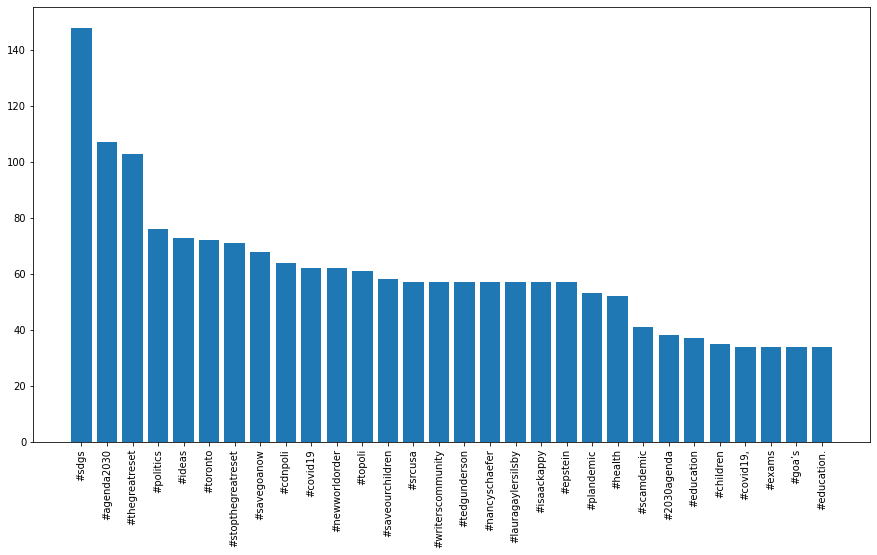

['#sdgs',
 '#agenda2030',
 '#thegreatreset',
 '#politics',
 '#ideas',
 '#toronto',
 '#stopthegreatreset',
 '#savegoanow',
 '#cdnpoli',
 '#covid19',
 '#newworldorder',
 '#topoli',
 '#saveourchildren',
 '#srcusa',
 '#writerscommunity',
 '#tedgunderson',
 '#nancyschaefer',
 '#lauragaylersilsby',
 '#isaackappy',
 '#epstein',
 '#plandemic',
 '#health',
 '#scamdemic',
 '#2030agenda',
 '#education',
 '#children',
 '#covid19,',
 '#exams',
 '#goa’s',
 '#education.']

In [141]:
plt.figure(figsize=(15,8))
plt.bar(list(StrongAgainst_HT.keys())[:30],list(StrongAgainst_HT.values())[:30])
plt.xticks(rotation=90)
plt.show()
list(StrongAgainst_HT.keys())[:30]

In [142]:
StrongAgainst_HT

{'#sdgs': 148,
 '#agenda2030': 107,
 '#thegreatreset': 103,
 '#politics': 76,
 '#ideas': 73,
 '#toronto': 72,
 '#stopthegreatreset': 71,
 '#savegoanow': 68,
 '#cdnpoli': 64,
 '#covid19': 62,
 '#newworldorder': 62,
 '#topoli': 61,
 '#saveourchildren': 58,
 '#srcusa': 57,
 '#writerscommunity': 57,
 '#tedgunderson': 57,
 '#nancyschaefer': 57,
 '#lauragaylersilsby': 57,
 '#isaackappy': 57,
 '#epstein': 57,
 '#plandemic': 53,
 '#health': 52,
 '#scamdemic': 41,
 '#2030agenda': 38,
 '#education': 37,
 '#children': 35,
 '#covid19,': 34,
 '#exams': 34,
 '#goa’s': 34,
 '#education.': 34,
 '#covid19?just': 34,
 '#agenda21': 31,
 '#climateaction': 30,
 '#nocia': 24,
 '#peace': 22,
 '#noglobalism': 22,
 '#nwo': 21,
 '#noimf': 21,
 '#worldeconomicforum,': 21,
 '#vaccines': 21,
 '#pfizer': 21,
 '#bigpharma': 21,
 '#justice': 20,
 '#wef': 20,
 '#noagenda21': 20,
 '#noworldbank': 20,
 '#sdg': 19,
 '#propaganda': 18,
 '#nowef': 18,
 '#makepacsnlobbiesillegal': 18,
 '#covid': 17,
 '#coronavirus': 17,
 '#

In [ ]:
topnum=3
StrongAgainst=PrintTopic(StrongAgainst,topnum,20)

for i in range(topnum):
  print(*StrongAgainst[StrongAgainst['HateTopic']==i].sample(2)['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
  print('*'*100)

plt.hist(StrongAgainst['HateTopic'])
plt.show()